# Cargar datos 

In [11]:
import os
import numpy as np
from PIL import Image
from skimage.measure import moments, moments_normalized, moments_central, moments_hu

# --- Función para calcular Momentos de Flusser ---
def flusser_moments(image_array):
    # Convertir a binaria (opcional: ajustar umbral según dataset)
    thresh = image_array > image_array.mean()
    binary = thresh.astype(np.uint8)
    
    # Momentos centrales
    m = moments(binary)
    cr = moments_central(binary, center=(m[1,0] / m[0,0], m[0,1] / m[0,0]))
    nm = moments_normalized(cr)
    hu = moments_hu(nm)
    
    # Flusser = normalización logarítmica de Hu (para mayor estabilidad)
    flusser = -np.sign(hu) * np.log10(np.abs(hu) + 1e-30)
    return flusser

# --- Función para cargar dataset ---
def load_dataset(base_path, img_size=(128, 128)):
    data = []
    labels = []
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.endswith(".jpg") or filename.endswith(".png"):
                    img_path = os.path.join(folder_path, filename)
                    
                    # Leer imagen, escalar y pasar a gris
                    img = Image.open(img_path).convert("L").resize(img_size)
                    arr = np.array(img)
                    
                    # Extraer Momentos de Flusser
                    feats = flusser_moments(arr)
                    data.append(feats)
                    labels.append(folder)
    return np.array(data), np.array(labels)

# --- Rutas ---
train_path = r"D:\Datases_CD\7mo\Datos_Masivos_2\Tareas\T3\Dataset of Tomato Leaves\Dataset of Tomato Leaves\plantvillage\Preprocessed data"
test_path  = r"D:\Datases_CD\7mo\Datos_Masivos_2\Tareas\T3\Dataset of Tomato Leaves\Dataset of Tomato Leaves\taiwan\data augmentation\Test"
# --- Cargar train y test ---
X_train, y_train = load_dataset(train_path)
X_test, y_test   = load_dataset(test_path)

print("Train shape:", X_train.shape, "Clases:", set(y_train))
print("Test shape:", X_test.shape, "Clases:", set(y_test))


Train shape: (14531, 7) Clases: {np.str_('healthy227'), np.str_('Late_blight227'), np.str_('Target_Spot227'), np.str_('Tomato_mosaic_virus227'), np.str_('Two-spotted_spider_mite227'), np.str_('Bacterial_spot227'), np.str_('Tomato_Yellow_Leaf_Curl_Virus227'), np.str_('Early_blight227'), np.str_('Septoria_leaf_spot227'), np.str_('Leaf_Mold227')}
Test shape: (921, 7) Clases: {np.str_('Bacterial spot'), np.str_('Late blight'), np.str_('Black mold'), np.str_('powdery mildew'), np.str_('health'), np.str_('Gray spot')}


In [12]:
# --- Comparar similitud (distancia euclidiana promedio entre clases) ---
from scipy.spatial.distance import cdist

dist_matrix = cdist(X_test, X_train, metric="euclidean")

# Para cada clase de test, vemos la clase de train más cercana
closest = []
for i, cls in enumerate(y_test):
    idx_min = dist_matrix[i].argmin()
    closest.append((cls, y_train[idx_min]))

print("\nMapeo aproximado de clases test → train:")
for t, tr in closest[:]:  # mostramos los primeros 20 ejemplos
    print(f"{t:20s} → {tr}")


Mapeo aproximado de clases test → train:
Bacterial spot       → Septoria_leaf_spot227
Bacterial spot       → Septoria_leaf_spot227
Bacterial spot       → healthy227
Bacterial spot       → Bacterial_spot227
Bacterial spot       → Tomato_Yellow_Leaf_Curl_Virus227
Bacterial spot       → healthy227
Bacterial spot       → Target_Spot227
Bacterial spot       → Target_Spot227
Bacterial spot       → Bacterial_spot227
Bacterial spot       → Tomato_Yellow_Leaf_Curl_Virus227
Bacterial spot       → Septoria_leaf_spot227
Bacterial spot       → Leaf_Mold227
Bacterial spot       → Leaf_Mold227
Bacterial spot       → Tomato_Yellow_Leaf_Curl_Virus227
Bacterial spot       → Two-spotted_spider_mite227
Bacterial spot       → Septoria_leaf_spot227
Bacterial spot       → Tomato_Yellow_Leaf_Curl_Virus227
Bacterial spot       → healthy227
Bacterial spot       → healthy227
Bacterial spot       → Tomato_Yellow_Leaf_Curl_Virus227
Bacterial spot       → Tomato_Yellow_Leaf_Curl_Virus227
Bacterial spot       → Sep

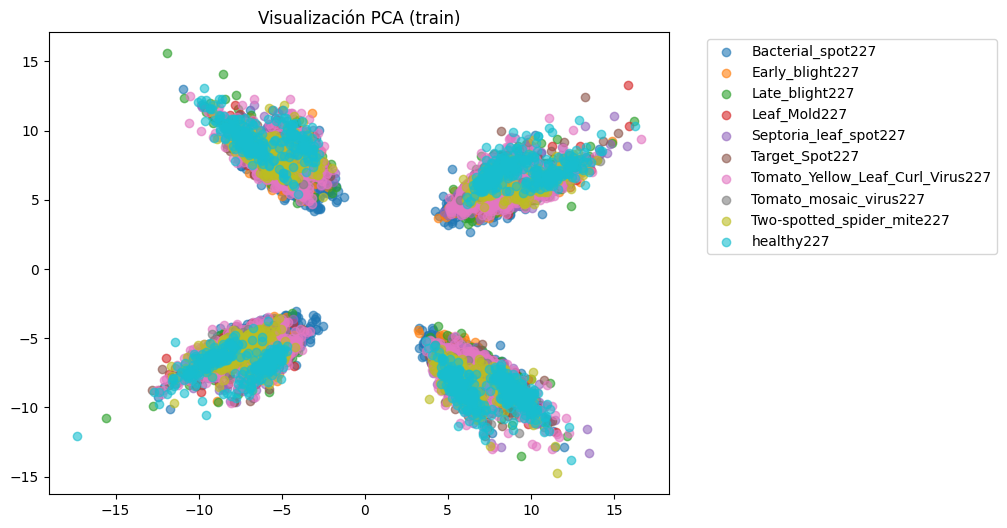

In [13]:
from sklearn.decomposition import PCA, NMF, TruncatedSVD
import matplotlib.pyplot as plt

# --- PCA ---
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.figure(figsize=(8,6))
for cls in np.unique(y_train):
    idx = y_train == cls
    plt.scatter(X_train_pca[idx,0], X_train_pca[idx,1], label=cls, alpha=0.6)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.title("Visualización PCA (train)")
plt.show()

In [14]:
# --- SVD (Truncated SVD, útil para datos dispersos) ---
svd = TruncatedSVD(n_components=2)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

In [15]:
# --- NMF (solo funciona si los datos son >= 0) ---
nmf = NMF(n_components=2, init="random", random_state=0, max_iter=500)
X_train_nmf = nmf.fit_transform(np.abs(X_train))   # aseguramos no-negatividad
X_test_nmf = nmf.transform(np.abs(X_test))

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# --- KNN ---
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("Resultados KNN:")
print(classification_report(y_test, y_pred_knn))

# --- SVM ---
svm = SVC(kernel="rbf", gamma="scale")
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("Resultados SVM:")
print(classification_report(y_test, y_pred_svm))


Resultados KNN:
                                  precision    recall  f1-score   support

                  Bacterial spot       0.00      0.00      0.00     146.0
               Bacterial_spot227       0.00      0.00      0.00       0.0
                      Black mold       0.00      0.00      0.00      99.0
                 Early_blight227       0.00      0.00      0.00       0.0
                       Gray spot       0.00      0.00      0.00     129.0
                     Late blight       0.00      0.00      0.00     136.0
                  Late_blight227       0.00      0.00      0.00       0.0
                    Leaf_Mold227       0.00      0.00      0.00       0.0
           Septoria_leaf_spot227       0.00      0.00      0.00       0.0
                  Target_Spot227       0.00      0.00      0.00       0.0
Tomato_Yellow_Leaf_Curl_Virus227       0.00      0.00      0.00       0.0
          Tomato_mosaic_virus227       0.00      0.00      0.00       0.0
      Two-spotted_spi

c:\Users\ENRIQUE\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ENRIQUE\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ENRIQUE\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Resultados SVM:
                                  precision    recall  f1-score   support

                  Bacterial spot       0.00      0.00      0.00     146.0
               Bacterial_spot227       0.00      0.00      0.00       0.0
                      Black mold       0.00      0.00      0.00      99.0
                       Gray spot       0.00      0.00      0.00     129.0
                     Late blight       0.00      0.00      0.00     136.0
                  Late_blight227       0.00      0.00      0.00       0.0
Tomato_Yellow_Leaf_Curl_Virus227       0.00      0.00      0.00       0.0
                          health       0.00      0.00      0.00     170.0
                      healthy227       0.00      0.00      0.00       0.0
                  powdery mildew       0.00      0.00      0.00     241.0

                        accuracy                           0.00     921.0
                       macro avg       0.00      0.00      0.00     921.0
                    

c:\Users\ENRIQUE\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ENRIQUE\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ENRIQUE\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# -----------------------------
# 1. Función para cargar imágenes
# -----------------------------
def load_images_from_folder(folder, label, size=(64,64)):
    data = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert("L")  # escala de grises
            img = img.resize(size)
            arr = np.array(img)

            # Feature extractor: histograma normalizado (ejemplo)
            hist, _ = np.histogram(arr, bins=32, range=(0,255))
            hist = hist / np.sum(hist)

            data.append(hist)
            labels.append(label)
        except:
            continue
    return data, labels

In [2]:
# -----------------------------
# 2. Cargar dataset de entrenamiento
# -----------------------------
train_dir = r"D:\Datases_CD\7mo\Datos_Masivos_2\Tareas\T3\Dataset of Tomato Leaves\Dataset of Tomato Leaves\plantvillage\Preprocessed data"
classes_train = os.listdir(train_dir)

X_train_all, y_train_all = [], []
for cls in classes_train:
    folder = os.path.join(train_dir, cls)
    data, labels = load_images_from_folder(folder, label=cls)
    X_train_all.extend(data)
    y_train_all.extend(labels)

X_train_all = np.array(X_train_all)
y_train_all = np.array(y_train_all)

print("Train set:", X_train_all.shape)

Train set: (14531, 32)


In [3]:
# -----------------------------
# 3. Cargar dataset de prueba
# -----------------------------
test_dir = r"D:\Datases_CD\7mo\Datos_Masivos_2\Tareas\T3\Dataset of Tomato Leaves\Dataset of Tomato Leaves\taiwan\data augmentation\Test"
classes_test = os.listdir(test_dir)

X_test_all, y_test_all = [], []
for cls in classes_test:
    folder = os.path.join(test_dir, cls)
    data, labels = load_images_from_folder(folder, label=cls)
    X_test_all.extend(data)
    y_test_all.extend(labels)

X_test_all = np.array(X_test_all)
y_test_all = np.array(y_test_all)

print("Test set:", X_test_all.shape)

Test set: (998, 32)


In [5]:
# -----------------------------
# 4. Normalización conjunta
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_all)
X_test_scaled  = scaler.transform(X_test_all)

# -----------------------------
# 5. PCA/SVD/NMF (para visualización)
# -----------------------------
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

svd = TruncatedSVD(n_components=2)
X_train_svd = svd.fit_transform(X_train_scaled)
X_test_svd  = svd.transform(X_test_scaled)

nmf = NMF(n_components=2, init='random', random_state=42, max_iter=500)
X_train_nmf = nmf.fit_transform(np.abs(X_train_scaled))
X_test_nmf  = nmf.transform(np.abs(X_test_scaled))

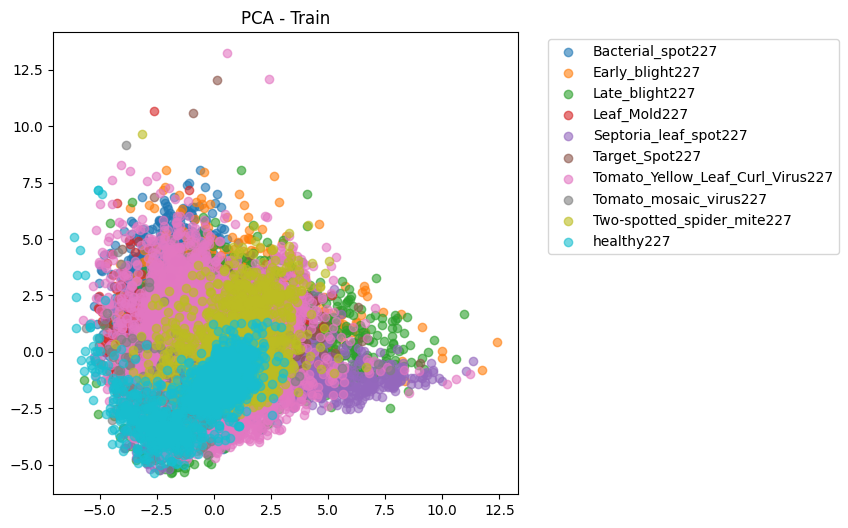

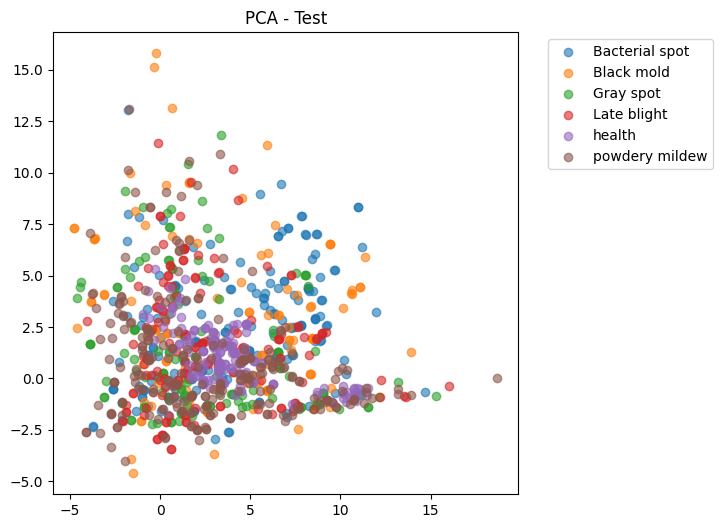

In [22]:

# -----------------------------
# 6. Visualización
# -----------------------------
def plot_latent(X_red, labels, title):
    plt.figure(figsize=(6,6))
    for cls in np.unique(labels):
        idxs = np.where(labels == cls)
        plt.scatter(X_red[idxs,0], X_red[idxs,1], label=cls, alpha=0.6)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.show()

plot_latent(X_train_pca, y_train_all, "PCA - Train")
plot_latent(X_test_pca, y_test_all, "PCA - Test")

In [23]:
# -----------------------------
# 7. Clasificación supervisada (ejemplo con PCA)
# -----------------------------
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(X_train_pca, y_train_all)

y_pred_knn = clf_knn.predict(X_test_pca)
print("KNN (PCA):")
print(classification_report(y_test_all, y_pred_knn))

clf_svm = SVC(kernel='linear')
clf_svm.fit(X_train_pca, y_train_all)

y_pred_svm = clf_svm.predict(X_test_pca)
print("SVM (PCA):")
print(classification_report(y_test_all, y_pred_svm))

KNN (PCA):
                                  precision    recall  f1-score   support

                  Bacterial spot       0.00      0.00      0.00     176.0
               Bacterial_spot227       0.00      0.00      0.00       0.0
                      Black mold       0.00      0.00      0.00     108.0
                 Early_blight227       0.00      0.00      0.00       0.0
                       Gray spot       0.00      0.00      0.00     135.0
                     Late blight       0.00      0.00      0.00     157.0
                  Late_blight227       0.00      0.00      0.00       0.0
                    Leaf_Mold227       0.00      0.00      0.00       0.0
           Septoria_leaf_spot227       0.00      0.00      0.00       0.0
                  Target_Spot227       0.00      0.00      0.00       0.0
Tomato_Yellow_Leaf_Curl_Virus227       0.00      0.00      0.00       0.0
      Two-spotted_spider_mite227       0.00      0.00      0.00       0.0
                          

c:\Users\ENRIQUE\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ENRIQUE\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ENRIQUE\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

SVM (PCA):
                                  precision    recall  f1-score   support

                  Bacterial spot       0.00      0.00      0.00     176.0
               Bacterial_spot227       0.00      0.00      0.00       0.0
                      Black mold       0.00      0.00      0.00     108.0
                 Early_blight227       0.00      0.00      0.00       0.0
                       Gray spot       0.00      0.00      0.00     135.0
                     Late blight       0.00      0.00      0.00     157.0
           Septoria_leaf_spot227       0.00      0.00      0.00       0.0
Tomato_Yellow_Leaf_Curl_Virus227       0.00      0.00      0.00       0.0
                          health       0.00      0.00      0.00     170.0
                  powdery mildew       0.00      0.00      0.00     252.0

                        accuracy                           0.00     998.0
                       macro avg       0.00      0.00      0.00     998.0
                    weigh

c:\Users\ENRIQUE\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ENRIQUE\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ENRIQUE\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

DBSCAN clusters (Test set):
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


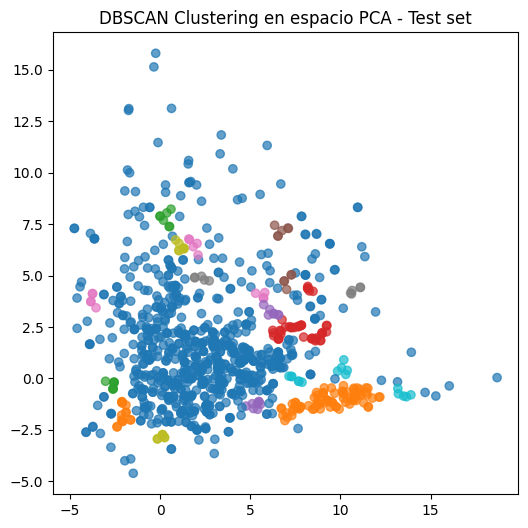

In [25]:
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Ajustar parámetros según dataset
clusters = dbscan.fit_predict(X_test_pca)

print("DBSCAN clusters (Test set):")
print(np.unique(clusters))

# Visualizar clusters DBSCAN
plt.figure(figsize=(6,6))
plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=clusters, cmap="tab10", alpha=0.7)
plt.title("DBSCAN Clustering en espacio PCA - Test set")
plt.show()

Train set: (14531, 32)
Test set : (998, 32)


c:\Users\ENRIQUE\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


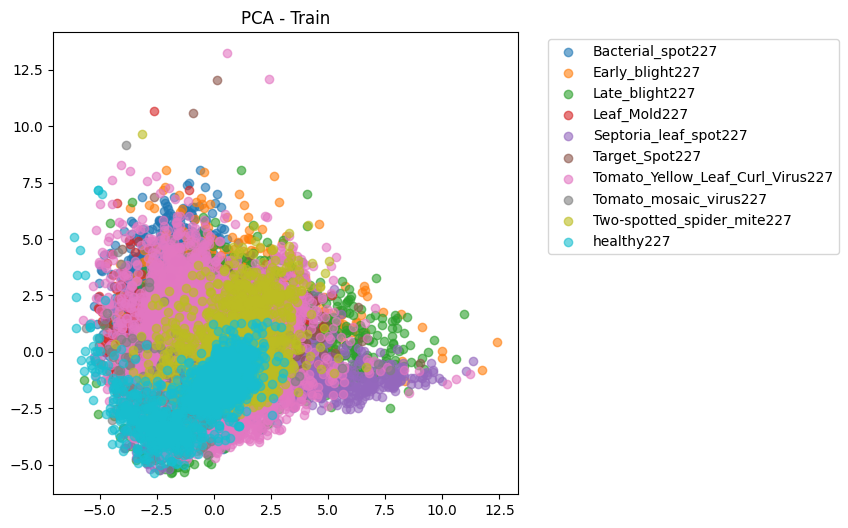

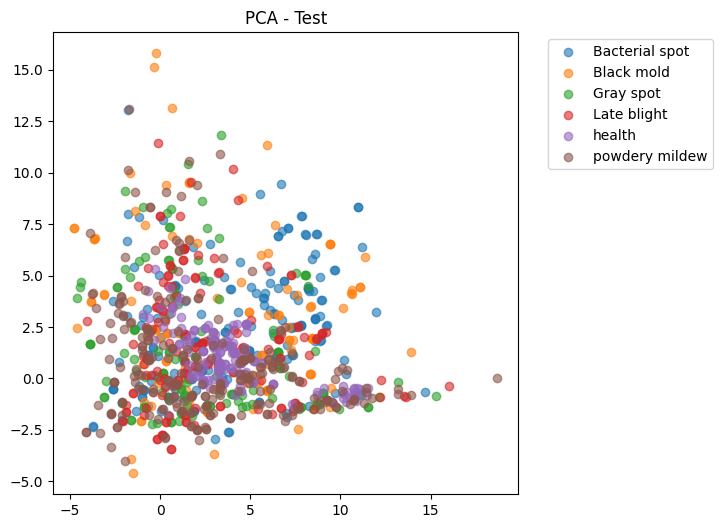

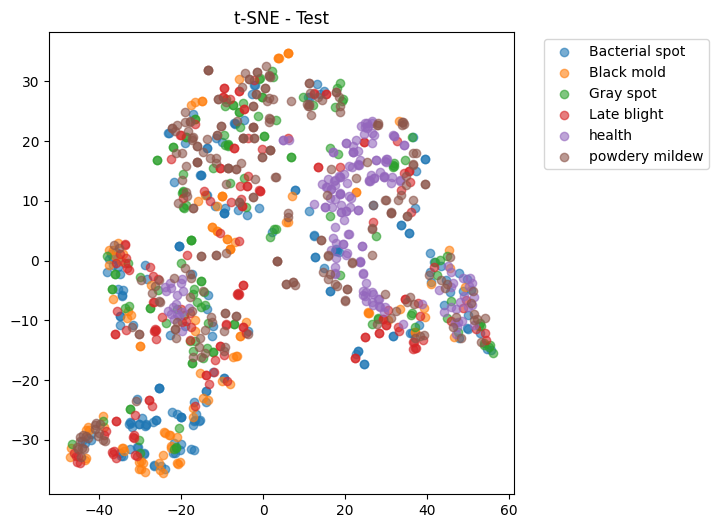

SVM (PCA) - clases coincidentes:
                precision    recall  f1-score   support

Bacterial spot       0.11      0.12      0.12       176
    Black mold       0.00      0.00      0.00       108
     Gray spot       0.00      0.00      0.00       135
   Late blight       0.14      0.62      0.22       157
        health       0.00      0.00      0.00       170
powdery mildew       0.00      0.00      0.00       252

      accuracy                           0.12       998
     macro avg       0.04      0.12      0.06       998
  weighted avg       0.04      0.12      0.06       998

DBSCAN clusters encontrados: [-1]
DBSCAN - Adjusted Rand Index: 0.0000
DBSCAN - Adjusted Mutual Info: 0.0000


c:\Users\ENRIQUE\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ENRIQUE\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ENRIQUE\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

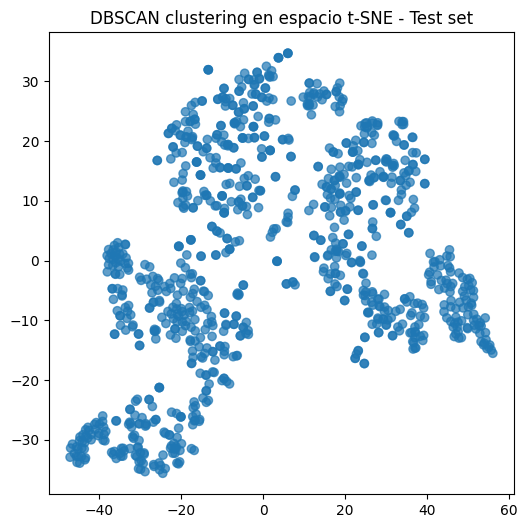

In [26]:
import os
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# -----------------------------
# 1. Función para cargar imágenes
# -----------------------------
def load_images_from_folder(folder, label, size=(64,64)):
    data = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert("L")  # escala de grises
            img = img.resize(size)
            arr = np.array(img)

            # Feature extractor: histograma normalizado
            hist, _ = np.histogram(arr, bins=32, range=(0,255))
            hist = hist / np.sum(hist)

            data.append(hist)
            labels.append(label)
        except:
            continue
    return data, labels

# -----------------------------
# 2. Mapear nombres de clases train -> test
# -----------------------------
class_mapping = {
    "healthy227": "health",
    "Late_blight227": "Late blight",
    "Bacterial_spot227": "Bacterial spot"
    # otras clases no aparecen en test (ej. "Black mold", "powdery mildew")
}

# -----------------------------
# 3. Cargar datasets (train y test)
# -----------------------------
train_dir = r"D:\Datases_CD\7mo\Datos_Masivos_2\Tareas\T3\Dataset of Tomato Leaves\Dataset of Tomato Leaves\plantvillage\Preprocessed data"
test_dir = r"D:\Datases_CD\7mo\Datos_Masivos_2\Tareas\T3\Dataset of Tomato Leaves\Dataset of Tomato Leaves\taiwan\data augmentation\Test"


classes_train = os.listdir(train_dir)
classes_test  = os.listdir(test_dir)

X_train_all, y_train_all = [], []
for cls in classes_train:
    folder = os.path.join(train_dir, cls)
    data, labels = load_images_from_folder(folder, label=cls)
    X_train_all.extend(data)
    y_train_all.extend(labels)

X_test_all, y_test_all = [], []
for cls in classes_test:
    folder = os.path.join(test_dir, cls)
    data, labels = load_images_from_folder(folder, label=cls)
    X_test_all.extend(data)
    y_test_all.extend(labels)

X_train_all = np.array(X_train_all)
y_train_all = np.array(y_train_all)
X_test_all  = np.array(X_test_all)
y_test_all  = np.array(y_test_all)

print("Train set:", X_train_all.shape)
print("Test set :", X_test_all.shape)

# -----------------------------
# 4. Normalización
# -----------------------------
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_all)
X_test_scaled  = scaler.transform(X_test_all)

# -----------------------------
# 5. Reducción de dimensionalidad
# -----------------------------
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

svd = TruncatedSVD(n_components=2)
X_train_svd = svd.fit_transform(X_train_scaled)
X_test_svd  = svd.transform(X_test_scaled)

nmf = NMF(n_components=2, init='random', random_state=42, max_iter=500)
X_train_nmf = nmf.fit_transform(np.abs(X_train_scaled))
X_test_nmf  = nmf.transform(np.abs(X_test_scaled))

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_test_tsne = tsne.fit_transform(X_test_scaled)

# -----------------------------
# 6. Visualización
# -----------------------------
def plot_latent(X_red, labels, title):
    plt.figure(figsize=(6,6))
    for cls in np.unique(labels):
        idxs = np.where(labels == cls)
        plt.scatter(X_red[idxs,0], X_red[idxs,1], label=cls, alpha=0.6)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.show()

plot_latent(X_train_pca, y_train_all, "PCA - Train")
plot_latent(X_test_pca, y_test_all, "PCA - Test")
plot_latent(X_test_tsne, y_test_all, "t-SNE - Test")

# -----------------------------
# 7. Clasificación supervisada (solo clases mapeadas)
# -----------------------------
mapped_y_train = np.array([class_mapping.get(lbl, None) for lbl in y_train_all])
valid_idx = mapped_y_train != None
X_train_supervised = X_train_pca[valid_idx]
y_train_supervised = mapped_y_train[valid_idx]

# Entrenamos solo en clases coincidentes
clf_svm = SVC(kernel='linear')
clf_svm.fit(X_train_supervised, y_train_supervised)
y_pred_svm = clf_svm.predict(X_test_pca)
print("SVM (PCA) - clases coincidentes:")
print(classification_report(y_test_all, y_pred_svm))

# -----------------------------
# 8. DBSCAN (clustering no supervisado en Test set)
# -----------------------------
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_test_tsne)

print("DBSCAN clusters encontrados:", np.unique(clusters))

# Métricas de clustering
ari = adjusted_rand_score(y_test_all, clusters)
ami = adjusted_mutual_info_score(y_test_all, clusters)

print(f"DBSCAN - Adjusted Rand Index: {ari:.4f}")
print(f"DBSCAN - Adjusted Mutual Info: {ami:.4f}")

# Visualización clusters DBSCAN
plt.figure(figsize=(6,6))
plt.scatter(X_test_tsne[:,0], X_test_tsne[:,1], c=clusters, cmap="tab10", alpha=0.7)
plt.title("DBSCAN clustering en espacio t-SNE - Test set")
plt.show()


In [2]:
import os
import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ===========================
# 1. Generador de imágenes (carga por lotes)
# ===========================
def image_generator(folder_path, target_size=(227,227), batch_size=100):
    class_names = sorted(os.listdir(folder_path))
    X, y = [], []
    while True:  # bucle infinito -> generador
        for label, class_name in enumerate(class_names):
            class_folder = os.path.join(folder_path, class_name)
            if not os.path.isdir(class_folder):
                continue
            for fname in os.listdir(class_folder):
                img_path = os.path.join(class_folder, fname)
                try:
                    img = load_img(img_path, target_size=target_size)
                    img_array = img_to_array(img) / 255.0
                    X.append(img_array.flatten())
                    y.append(label)
                except:
                    continue
                # cuando llegamos al tamaño del batch, yield
                if len(X) == batch_size:
                    yield np.array(X), np.array(y), class_names
                    X, y = [], []

# ===========================
# 2. Rutas de datasets
# ===========================
train_folder = r"D:\Datases_CD\7mo\Datos_Masivos_2\Tareas\T3\Dataset of Tomato Leaves\Dataset of Tomato Leaves\plantvillage\Preprocessed data" 
test_folder = r"D:\Datases_CD\7mo\Datos_Masivos_2\Tareas\T3\Dataset of Tomato Leaves\Dataset of Tomato Leaves\taiwan\data augmentation\Test"  

# ===========================
# 3. Ajustar IncrementalPCA en TRAIN
# ===========================
n_components = 50
batch_size = 100
num_train_images = 14531  # número real de imágenes en tu dataset PlantVillage

ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

# Primera pasada: ajustar PCA
gen = image_generator(train_folder, batch_size=batch_size)
for i, (X_batch, y_batch, class_names_train) in enumerate(gen):
    ipca.partial_fit(X_batch)
    print(f"[TRAIN PCA] Lote {i+1} procesado")
    if (i+1)*batch_size >= num_train_images:
        break

# Segunda pasada: transformar datos completos de train
X_train, y_train = [], []
gen = image_generator(train_folder, batch_size=batch_size)
for i, (X_batch, y_batch, class_names_train) in enumerate(gen):
    X_train.append(ipca.transform(X_batch))
    y_train.append(y_batch)
    if (i+1)*batch_size >= num_train_images:
        break

X_train = np.vstack(X_train)
y_train = np.hstack(y_train)

print(f"Train final: {X_train.shape}")

# ===========================
# 4. Entrenar clasificador con TRAIN
# ===========================
clf = SVC(kernel="rbf", C=10, gamma="scale")
clf.fit(X_train, y_train)

# ===========================
# 5. Evaluar en TEST (Taiwan) usando batches
# ===========================
num_test_images = 4976  
y_true, y_pred = [], []

gen = image_generator(test_folder, batch_size=batch_size)
for i, (X_batch, y_batch, class_names_test) in enumerate(gen):
    X_batch_pca = ipca.transform(X_batch)   # usar los mismos componentes del TRAIN
    preds = clf.predict(X_batch_pca)
    y_true.extend(y_batch)
    y_pred.extend(preds)
    print(f"[TEST] Lote {i+1} procesado")
    if (i+1)*batch_size >= num_test_images:
        break

# ===========================
# 6. Reporte final
# ===========================
print("=== Reporte de clasificación en Dataset Taiwan ===")
print(classification_report(y_true, y_pred, target_names=class_names_test))


[TRAIN PCA] Lote 1 procesado
[TRAIN PCA] Lote 2 procesado
[TRAIN PCA] Lote 3 procesado
[TRAIN PCA] Lote 4 procesado
[TRAIN PCA] Lote 5 procesado
[TRAIN PCA] Lote 6 procesado
[TRAIN PCA] Lote 7 procesado
[TRAIN PCA] Lote 8 procesado
[TRAIN PCA] Lote 9 procesado
[TRAIN PCA] Lote 10 procesado
[TRAIN PCA] Lote 11 procesado
[TRAIN PCA] Lote 12 procesado
[TRAIN PCA] Lote 13 procesado
[TRAIN PCA] Lote 14 procesado
[TRAIN PCA] Lote 15 procesado
[TRAIN PCA] Lote 16 procesado
[TRAIN PCA] Lote 17 procesado
[TRAIN PCA] Lote 18 procesado
[TRAIN PCA] Lote 19 procesado
[TRAIN PCA] Lote 20 procesado
[TRAIN PCA] Lote 21 procesado
[TRAIN PCA] Lote 22 procesado
[TRAIN PCA] Lote 23 procesado
[TRAIN PCA] Lote 24 procesado
[TRAIN PCA] Lote 25 procesado
[TRAIN PCA] Lote 26 procesado
[TRAIN PCA] Lote 27 procesado
[TRAIN PCA] Lote 28 procesado
[TRAIN PCA] Lote 29 procesado
[TRAIN PCA] Lote 30 procesado
[TRAIN PCA] Lote 31 procesado
[TRAIN PCA] Lote 32 procesado
[TRAIN PCA] Lote 33 procesado
[TRAIN PCA] Lote 34

ValueError: Number of classes, 8, does not match size of target_names, 6. Try specifying the labels parameter